In [1]:
import os   #used for directory work
import matplotlib as mpl
import matplotlib.pyplot as plt #used for creating plots
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
%matplotlib inline



In [2]:
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    
    return txt_files

def file_to_df(path):
    df= pd.read_csv(path,na_values = ['NAN', "00nan"], sep=" ")
    
    return df

In [3]:
def day_color(df, full_timestamp = True):
    dates = ["2018-03-05", "2018-03-06", "2018-03-17", "2018-05-09", "2018-05-10", \
            "2018-05-11", "2018-09-22", "2019-05-20", "2019-05-21", "2019-05-22", \
            "2019-05-29", "2019-05-31"]
    colors = ["navy", "maroon", "darkolivegreen", "darkorange", "plum", "turquoise", \
              "saddlebrown", "y", "goldenrod", "mediumseagreen", "indigo", "magenta"  ]
    
    
    if full_timestamp == True:
        for t in range(len(dates)):
            if df["TIMESTAMP"][0][:10] ==dates[t]:
                return colors[t]
                break
    if full_timestamp == False:
        for t in range(len(dates)):
            if str(pd.Timestamp(df["YYYY"][0],df["MM"][0],df["DD"][0]))[:10] == dates[t]:
                return colors[t]
                break

In [6]:
def quad_averages(quad_list, t_s, t_e ):            
    ###Finding the sums of the quadriants 
    cut_quad_list = list(quad_list[t_s:t_e])

    Q1, Q2 = cut_quad_list.count(1), cut_quad_list.count(2)
    Q3, Q4 = cut_quad_list.count(3), cut_quad_list.count(4)
    
    nan = cut_quad_list.count(0)        
    Q_sum = Q1 + Q2 + Q3 + Q4
    
    if Q_sum != 0: 
        Qlst_ave = [Q1/Q_sum, Q2/Q_sum, Q3/Q_sum, Q4/Q_sum]
    if Q_sum == 0:
        Qlst_ave = [0, 0, 0, 0]
    
    return Qlst_ave


def fire_start(df):    
    ### Finding the start of fire
    x_fire, fire_5sig = 9e10, np.nanmean(df["T"])+5*np.std(df["T"]) 
    for i in range(len(df["T"])):
        if df["T"][i] > fire_5sig:
            x_fire = i
            break
    
    return x_fire


def sonic_calculations(df, n, x_fire):
    ### pre-burn averaging index
    #30mins = 18000 15mins = 9000 10mins = 6000 5mins = 3000
    pre_brn_start, pre_brn_end = 0, n
    if n > 9000:
        pre_brn_start = n - 9000 #Making the pre-burn period max time of 30 min
    
    pre_brn_len = pre_brn_end - pre_brn_start
    #print(pre_brn_start,pre_brn_end)
    
    ### Getting the pre-fire averages
    W_mean = np.nanmean(df["W"][pre_brn_start:pre_brn_end])
    T_mean = np.nanmean(df["T"][pre_brn_start:pre_brn_end])
    
    ### Creating te Prime Lists
    
    W_prime, T_prime= list(np.full(len(df),np.nan)),list(np.full(len(df),np.nan))
    for i in range(len(df)):
        W_prime[i] = df["W"][i] - W_mean
        T_prime[i] = df["T"][i] - T_mean
    
    wt_prime_list = list(np.full(len(df),np.nan))
    for i in range(len(df)):
        wt_prime_list[i] = W_prime[i]*T_prime[i]
    
    ### Pulling the quadriants out of the lists    
    quad_list = list(np.full(len(df),0)) 
    for i in range(len(df)):
        #quad_mag.append(abs(W_prime[i]*T_prime[i]))
        if float(W_prime[i]) > 0 and float(T_prime[i]) > 0:
            quad_list[i] = 1
            continue
        if float(W_prime[i]) > 0 and float(T_prime[i]) < 0:
            quad_list[i] = 2
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) < 0:
            quad_list[i] = 3
            continue
        if float(W_prime[i]) < 0 and float(T_prime[i]) > 0:
            quad_list[i] = 4
            continue
            
    ### W'T' pre-burn averages
    pre_wt_prime_ave = np.nanmean(wt_prime_list[pre_brn_start:pre_brn_end])
    
    pre_Qlst = quad_averages(quad_list, pre_brn_start, pre_brn_end)

    ### Fire calculations
    brn_n = len(wt_prime_list[x_fire:])
    
    #30mins = 18000 15mins = 9000 10mins = 6000 5mins = 3000
    fire_end = len(df)-1 #the end of the fire period 
    if brn_n > 9000:
        fire_end = x_fire + 9000 #30mins after the fire
        brn_n = len(wt_prime_list[x_fire:fire_end])

    brn_wt_prime_ave = np.nanmean(wt_prime_list[x_fire:fire_end])
    brn_Qlst = quad_averages(quad_list, x_fire, fire_end)
    
    return pre_Qlst, pre_wt_prime_ave, pre_brn_len, brn_Qlst, brn_wt_prime_ave, brn_n
    
def burn_calculations(path, n):
    txt_files = text_finder(path)
    
    ### Load in the DF and find the begining of the fire of all sonics
    df_list, x_fire_lst = [], []
    for i in range(16):
        df = file_to_df(path + txt_files[i])
        x_fire_lst.append(fire_start(df))
        df_list.append(df)

    n_fire = min(x_fire_lst)
    dc = day_color(df_list[0])
    pre_burn_Q_lst, burn_Q_lst= [], []
    pre_WT_ave, brn_WT_ave = [],[]
    x_fire_lst, brn_n_lst= [], []
    for i in range(16):
        pre_Qlst, pre_wt_prime_ave, pre_brn_len, brn_Qlst,\
            brn_wt_prime_ave, brn_n = sonic_calculations(df_list[i],n, n_fire)
        
        pre_burn_Q_lst.append(pre_Qlst)
        pre_WT_ave.append(pre_wt_prime_ave)
        brn_WT_ave.append(brn_wt_prime_ave)
        burn_Q_lst.append(brn_Qlst)
        brn_n_lst.append(brn_n)
    
    brn_len_min = []
    for i in range(len(brn_n_lst)):
        brn_len_min.append(brn_n_lst[i]/(600))
        
    return pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, brn_n_lst,\
            brn_len_min, pre_brn_len, dc
    

Row: 0 Col: 0, Burn 04, (1/24)
Row: 0 Col: 1, Burn 05, (2/24)
Row: 0 Col: 2, Burn 06, (3/24)
Row: 0 Col: 3, Burn 11, (4/24)
Row: 0 Col: 4, Burn 20, (5/24)
Row: 1 Col: 0, Burn 21, (6/24)
Row: 1 Col: 1, Burn 22, (7/24)


/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice
/home/joey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice


Row: 1 Col: 2, Burn 23, (8/24)
Row: 1 Col: 3, Burn 24, (9/24)
Row: 1 Col: 4, Burn 25, (10/24)
Row: 2 Col: 0, Burn 26, (11/24)
Row: 2 Col: 1, Burn 29, (12/24)
Row: 2 Col: 2, Burn 30, (13/24)
Row: 2 Col: 3, Burn 34, (14/24)
Row: 2 Col: 4, Burn 03, (15/24)
Row: 3 Col: 0, Burn 03, (15/24)
Row: 3 Col: 1, Burn 09, (16/24)
Row: 3 Col: 2, Burn 18, (17/24)
Row: 3 Col: 3, Burn 28, (18/24)
Row: 3 Col: 4, Burn 33, (19/24)
Row: 4 Col: 0, Burn 01, (20/24)
Row: 4 Col: 1, Burn 02, (21/24)
Row: 4 Col: 2, Burn 13, (22/24)
Row: 4 Col: 3, Burn 27, (23/24)
Row: 4 Col: 4, Burn 32, (24/24)
CPU times: user 8min 28s, sys: 484 ms, total: 8min 29s
Wall time: 8min 29s


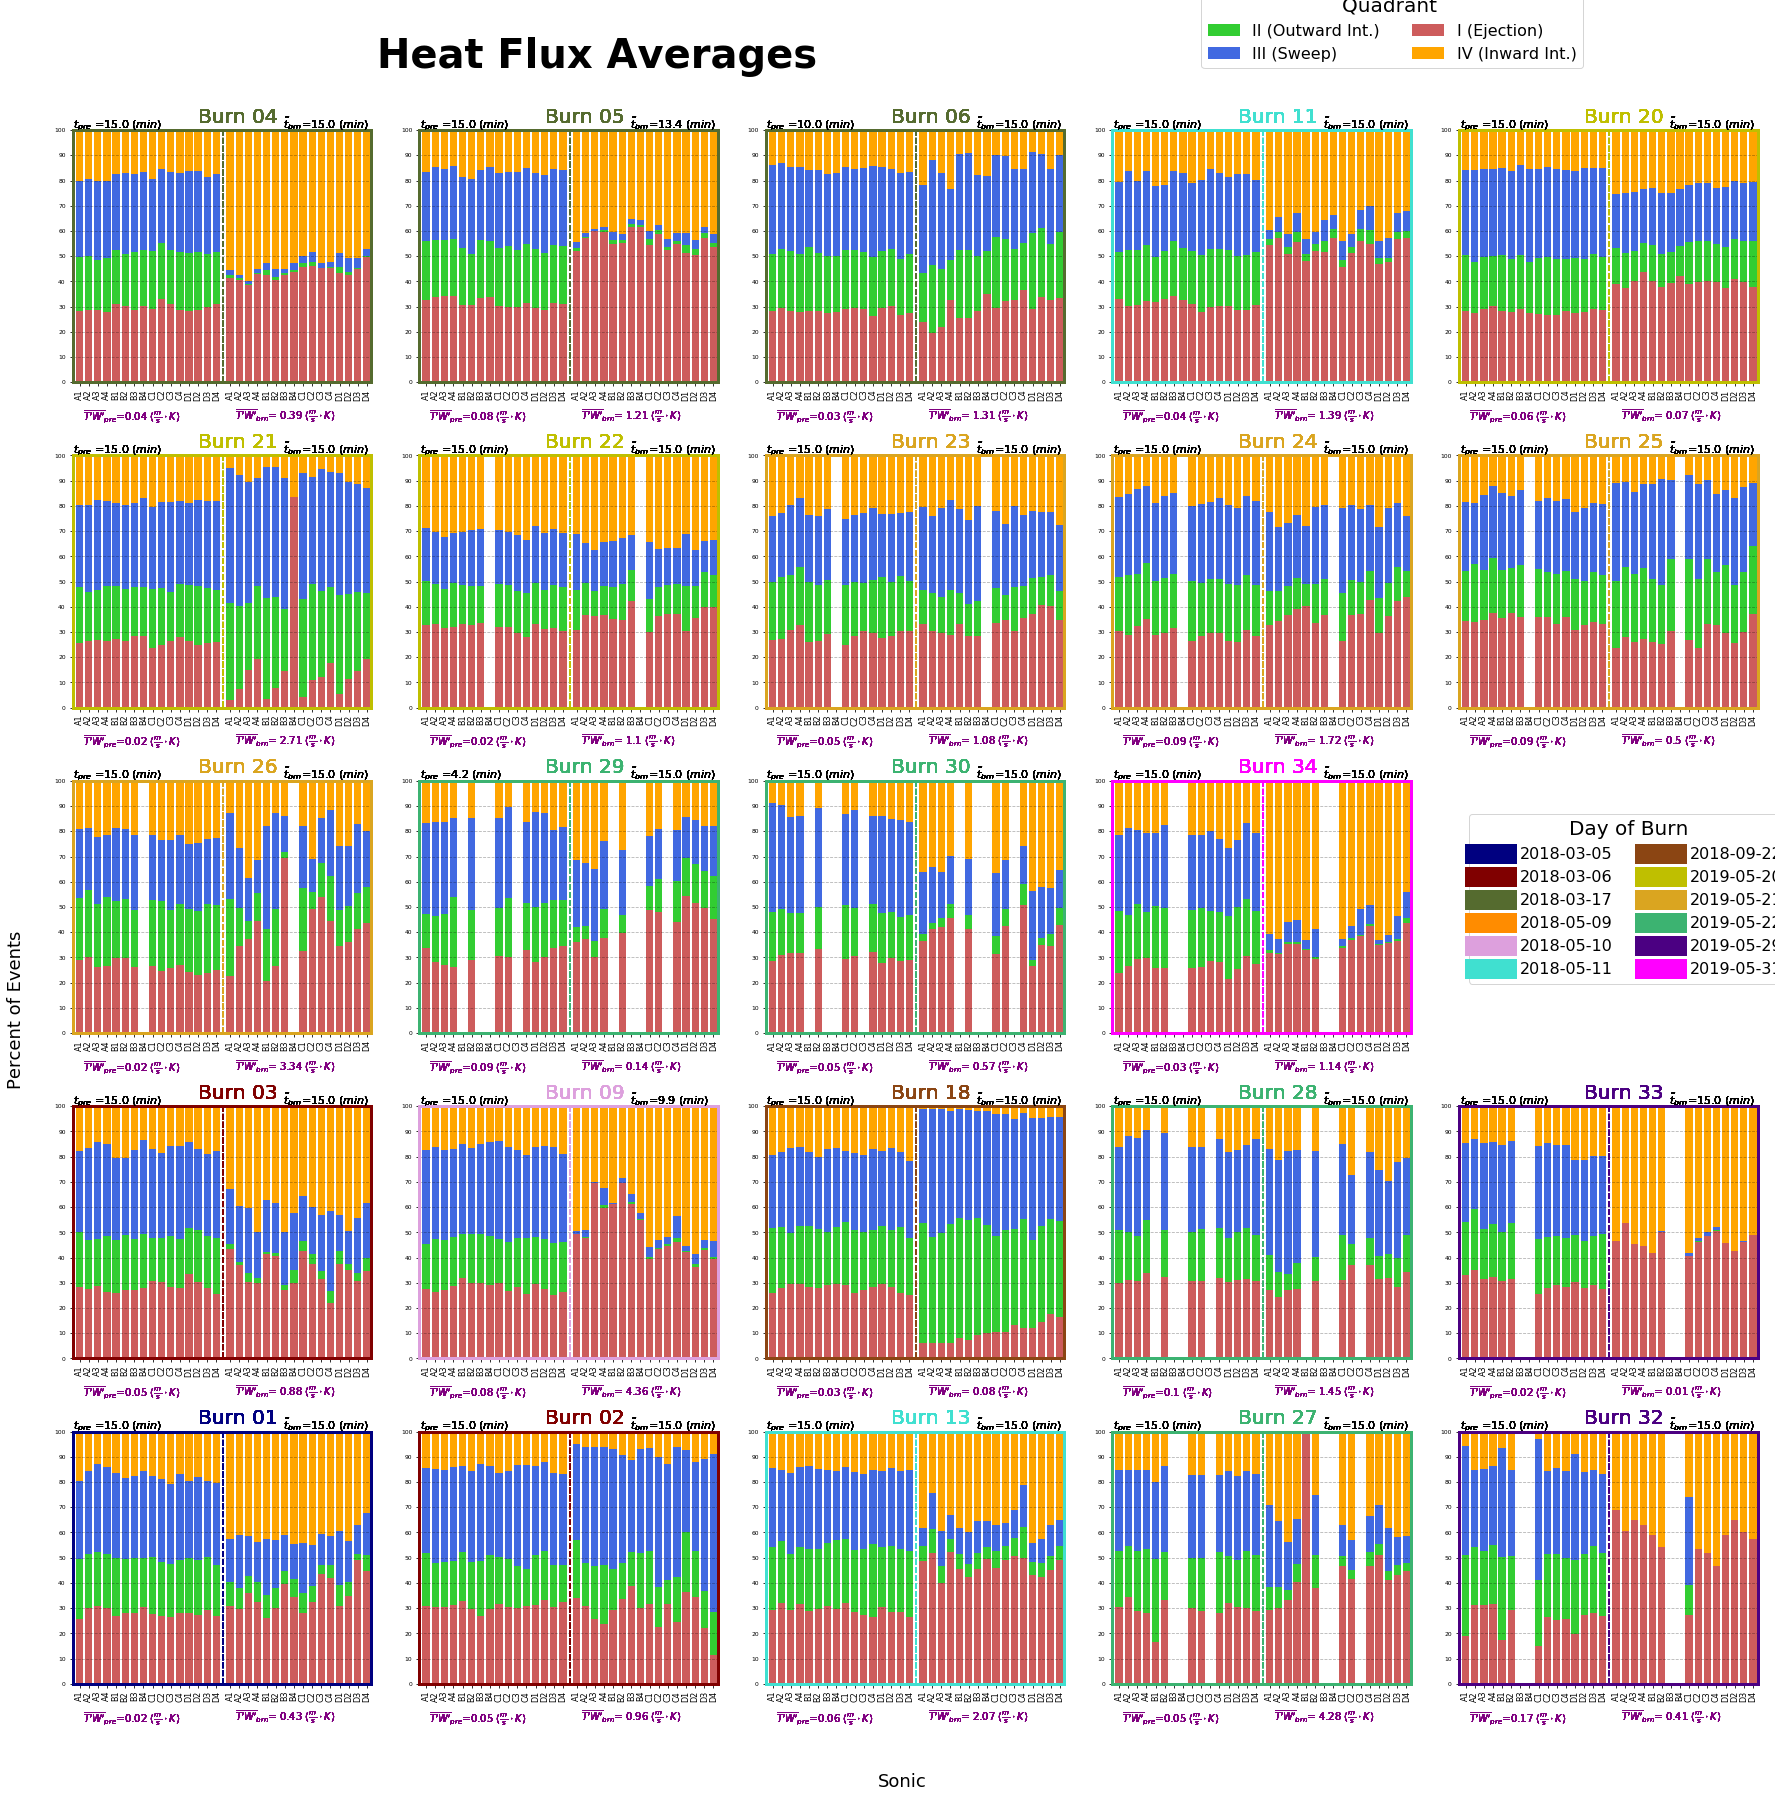

In [15]:
%%time
###### Date legend lines
dates = ["2018-03-05", "2018-03-06", "2018-03-17", "2018-05-09", "2018-05-10", \
            "2018-05-11", "2018-09-22", "2019-05-20", "2019-05-21", "2019-05-22", \
            "2019-05-29", "2019-05-31"]
colors = ["navy", "maroon", "darkolivegreen", "darkorange", "plum", "turquoise", \
              "saddlebrown", "y", "goldenrod", "mediumseagreen", "indigo", "magenta"  ]
custom_lines =[]
for i in range(len(dates)):
    custom_lines.append( Line2D([0], [0], color=colors[i], lw=20,markersize=2))

mpl.rcParams['axes.linewidth'] = 3 #set the value globally

###### Burn Constants 
n_list = [30000,15000,6000,30000,25000,25000,27000,45000,20000,25000,25000,2500, 15000,40000, \
         20000,20000,180000,27000,20000,\
         21000, 15000, 50000, 35000, 45000] 
#path = "/home/JoeySeitz/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-"
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-"#79 
#path = "/Users/joeyp//Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Full-Timestamp/Burn-" #w10
path_end = "/sonics/"
burns = ["04", "05", "06", "11", "20", "21", "22", "23", "24", "25", "26", "29", "30", "34", \
        "03", "09", "18", "28", "33", \
        "01", "02", "13", "27", "32" ]    

### Plotting stuff 
sonic_list = ["A1","A2","A3","A4", "B1","B2", "B3", "B4", "C1", "C2","C3", "C4", "D1", "D2", "D3", "D4"]*2
x_loc_1= list(np.arange(1,17,1))
x_loc_2 = list(np.arange (17.5,33,1))
x_loc = x_loc_1 + x_loc_2

y_loc =np.arange(0.0,1.1,0.1)
y_tick_names  = np.arange(0,110,10)
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=(26,26))#, sharey=True)
### Keep out of loop
file_count = 0
for row in range(5):
    for col in range(5):
        fmt = "Row: {} Col: {}, Burn {}, ({}/24)"
        print(fmt.format(row,col,burns[file_count],file_count+1))
        axs = ax[ row, col]
        if col == 4 and row ==2:
            axs.set_visible(False)
            continue
        
        burn_path= str(path + str(burns[file_count])+path_end)
        #print("Now on Burn: ",str(burns[file_count]))
        pre_burn_Q_lst, burn_Q_lst,  pre_WT_ave, brn_WT_ave, x_fire_lst, brn_n_lst,\
            brn_len_min, pre_brn_len, dc = burn_calculations(burn_path, n_list[file_count])
        
        
            
        x1, x2 = 1, 17.5
        for i in range(16):
            axs.bar(x1, pre_burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=pre_burn_Q_lst[i][0])
            axs.bar(x1, pre_burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1])
            axs.bar(x1, pre_burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x1, pre_burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=pre_burn_Q_lst[i][0]+pre_burn_Q_lst[i][1]+pre_burn_Q_lst[i][2])

            axs.bar(x2, burn_Q_lst[i][1],label = "II (Outward Int.)",color = "limegreen", bottom=burn_Q_lst[i][0])
            axs.bar(x2, burn_Q_lst[i][2],label = "III (Sweep)",color ="royalblue", bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1])
            axs.bar(x2, burn_Q_lst[i][0],label = "I (Ejection)",color="indianred")
            axs.bar(x2, burn_Q_lst[i][3],label = "IV (Inward Int.)",color = "orange",  bottom=burn_Q_lst[i][0]+burn_Q_lst[i][1]+burn_Q_lst[i][2])

            axs.vlines(16.75,1,0, linestyle = "--", color = dc)#"grey")#alpha = .7)
            #axs.vlines(33.25,1,0, linestyle = "--",color = "grey")
            axs.set_ylim(0,1)
            axs.set_xlim(.25,33)
            axs.yaxis.grid(linestyle='--', color = "k", alpha = .3)
            axs.set_yticks(y_loc) 
            axs.set_yticklabels(y_tick_names, fontsize = 6)


            #axs.set_title("Pre-Burn Period"+"  "*35+ "Burn Period", fontsize = 16, x = .2)
            #axs.set_ylabel("Percent of Events", fontsize = 10)
            #axs.set_xlabel("Sonic", fontsize = 18, x=.47)
            pre_txt = r" ${t}_{pre}$ ="+str(round(pre_brn_len/600,1))+" $(min)$"
            brn_txt =r" $\tilde{t}_{brn}$="+str(round(np.median(brn_len_min),1))+" $(min)$"
            axs.text(14,1.03, "Burn "+str(burns[file_count]), fontsize = 20, color = dc)
            
            axs.text(23,1.01,brn_txt, fontsize = 11, weight = "light"  )
            axs.text(0,1.01,pre_txt, fontsize = 11, weight = "light" )

            axs.text(1,-.15," $\overline{T{}'W{}'}_{pre}$=" + str(round(np.nanmean(pre_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)" , fontsize = 10, color = "purple")
            axs.text(18,-.15, "$\overline{T{}'W{}'}_{brn}$= " + str(round(np.nanmean(brn_WT_ave), 2))+ r" ($\frac{m}{s} \cdot {K}$)", fontsize = 10, color = "purple")

            #axs2 = axs.twinx()
            #axs2.boxplot(brn_len_min,widths=1, positions = [34.25])

            #axs2.set_yticks(axs2_ytic_loc)
            #axs2.tick_params(axis="y", labelsize=6)
            #for i in range(len(brn_len_min)):
            #    if brn_len_min[i]> np.median(brn_len_min)+stats.iqr(brn_len_min)*1.5 or \
            #        brn_len_min[i]<np.median(brn_len_min)-stats.iqr(brn_len_min)*1.5:

            #       axs2.text(35.25, brn_len_min[i], sonic_list[i],fontsize=6, weight = "light", color = "b")

            axs.set_xticks(x_loc)
            axs.set_xticklabels(sonic_list, fontsize=8,rotation='vertical')   
            
            #axs.tick_params(color='green', labelcolor='green')
            for spine in axs.spines.values():
                spine.set_edgecolor(dc)
            #axs.set_facecolor(dc)
            #axs.setp( color=dc)#[ax.get_xticklines(), ax.get_yticklines()],
            
            x1 += 1
            x2 += 1
        file_count += 1 
    
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles[:4], labels[:4], ncol = 2, fontsize = 16, bbox_to_anchor=(.85, .97), title = "Quadrant ", title_fontsize = 20) #, framealpha = .8)
fig.legend(custom_lines, dates, ncol =2,  bbox_to_anchor=(.96, .53), fontsize = 16, title = "Day of Burn", title_fontsize = 20)
fig.suptitle("Heat Flux Averages", fontsize = 40, y = .95, x = .33, fontweight = "bold")
fig.text(0.015,0.39,"Percent of Events", rotation  = 90, fontsize = 18)
#fig.text(0.97, 0.375,"Burn Duration (mins)", rotation = 270, fontsize = 18)
fig.text(0.48,0.015, "Sonic", fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(hspace=0.29,wspace=0.16, top=0.9, left = 0.05, right = .95, bottom = .07)

fig.savefig("Grouping-Heat-Flux-aveplot_15min-15min_03.png", dpi = 350)
### Took 56mins and 45s to run on W10 Desktop
## Took 1hr 17min to run on 134
###New time of 15min 4s!!!(134 at 30min)

In [ ]:
n_list = [21000,15000,20000,30000,15000,6000,25000,18000,30000,60000,50000,180000,40000,25000,25000,27000,\
         45000,20000,25000,25000,35000,27000,25000,15000,35000,45000,20000,40000]

In [15]:
n = 15000

In [33]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Split-Times/Burn-02/sonics/A1_UVWT_Burn-02.txt"#79 
df = file_to_df(path)
str(pd.Timestamp(df["YYYY"][0],df["MM"][0],df["DD"][0]))[:10]#["TIMESTAMP"][0][:10]

'2018-03-06'

In [38]:
day_color(df,False)

'maroon'

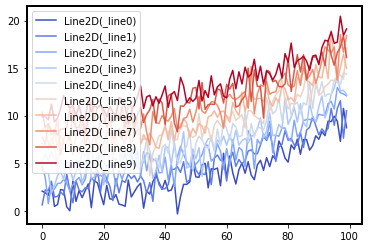

In [10]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

N = 10
data = [np.logspace(0, 1, 100) + np.random.randn(100) + ii for ii in range(N)]
data = np.array(data).T
cmap = plt.cm.coolwarm
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(lines)

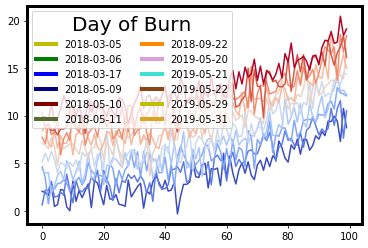

In [59]:


cust_lines =[]
for i in range(len(dates)):
    custom_lines.append( Line2D([0], [0], color=colors[i], lw=200, markersize = 1000))
dates = ["2018-03-05", "2018-03-06", "2018-03-17", "2018-05-09", "2018-05-10", \
            "2018-05-11", "2018-09-22", "2019-05-20", "2019-05-21", "2019-05-22", \
            "2019-05-29", "2019-05-31"]
colors = ["navy", "maroon", "darkolivegreen", "darkorange", "plum", "turquoise", \
              "saddlebrown", "y", "goldenrod", "mediumseagreen", "indigo", "magenta"  ]

fig, ax = plt.subplots()
lines = ax.plot(data)
ax.legend(custom_lines, dates, ncol =2, title = "Day of Burn", title_fontsize = 20, markerscale = 60)